In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import gymnasium as gym
import gym_trading_env

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from RLTrade.agent import DQNAgent, XGBoostAgent
from RLTrade.utils import (
    stationaryDGP, 
    nonstationaryDGP, 
    # build_features, 
    # build_rolling_feature
    FeatureEngineering
)

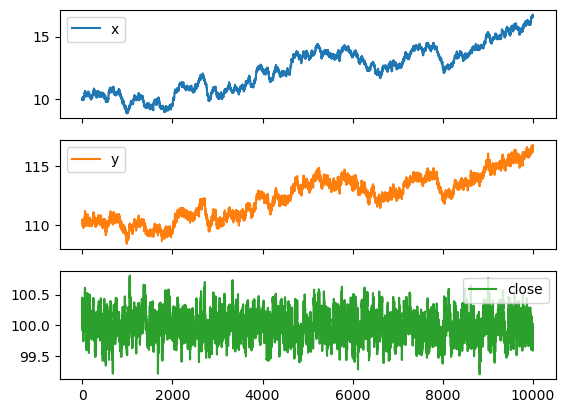

In [2]:
x, y = stationaryDGP()
spread = y - x
df = pd.DataFrame({'x': x, 'y': y, 'close': spread}) # close price of portfolio is the spread
df.plot(subplots=True)
plt.show()

In [3]:
# confirm the x, y pair is cointegrated, such that spread is stationary
x_ols = sm.add_constant(x)
ols = sm.OLS(y, x_ols).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 6.779e+05
Date:                Mon, 03 Mar 2025   Prob (F-statistic):               0.00
Time:                        00:15:27   Log-Likelihood:                 912.58
No. Observations:               10000   AIC:                            -1821.
Df Residuals:                    9998   BIC:                            -1807.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        100.0474      0.015   6616.560      0.0

In [4]:
adfuller_test = adfuller(spread)
print(f'ADF Statistic: {adfuller_test[0]}')
print(f'p-value: {adfuller_test[1]}')
print('Is the spread stationary? {}'.format('Yes' if adfuller_test[1] < 0.05 else 'No'))

ADF Statistic: -24.072035539645977
p-value: 0.0
Is the spread stationary? Yes


In [5]:
# build features
df_train = df.copy()

feature_config = {
    "window": 7, # 7 days window, pad with first value when window is not available
    "mode": "diff", # difference between current and previous close price
    "subtract_mean": False, # subtract mean from the window
}

fe = FeatureEngineering(df_train, main_feature_col="close")
fe.rolling_feature(**feature_config)
df_train = fe.df.copy()
df_train

,x,y,close,feature_rolling_0,feature_rolling_1,feature_rolling_2,feature_rolling_3,feature_rolling_4,feature_rolling_5,feature_rolling_6
0,9.976695,110.026495,100.049800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,9.990551,110.070197,100.079646,0.029845,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,9.994797,110.226770,100.231973,0.152328,0.029845,0.000000,0.000000,0.000000,0.000000,0.000000
3,9.933667,110.310651,100.376984,0.145011,0.152328,0.029845,0.000000,0.000000,0.000000,0.000000
4,10.032829,110.354142,100.321313,-0.055671,0.145011,0.152328,0.029845,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
9995,16.758558,116.513404,99.754846,-0.035523,-0.067464,0.178719,-0.025708,0.013132,0.103623,-0.030427
9996,16.731581,116.530838,99.799256,0.044410,-0.035523,-0.067464,0.178719,-0.025708,0.013132,0.103623
9997,16.741496,116.755935,100.014439,0.215183,0.044410,-0.035523,-0.067464,0.178719,-0.025708,0.013132
9998,16.716588,116.584431,99.867842,-0.146597,0.215183,0.044410,-0.035523,-0.067464,0.178719,-0.025708


In [6]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationaryDGP",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        dynamic_feature_functions = [],
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)

while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(position_index)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[0. 0. 0. 0. 0. 0. 0.]
Market Return : -0.10%   |   Portfolio Return : -62.19%   |   Position Changes : 6663   |   Episode Length : 10000   |   


In [7]:
# Train a DQN agent using training data from a stationary data generating process
agent = DQNAgent(n_observations=n_observations, n_actions=n_actions)
history_metrics, _ = agent.train(env, num_episodes=15) # Beware of overfitting when num_episodes is too high

Market Return : -0.10%   |   Portfolio Return : -34.45%   |   Position Changes : 5329   |   Episode Length : 10000   |   
Market Return : -0.10%   |   Portfolio Return : 34.37%   |   Position Changes : 3810   |   Episode Length : 10000   |   
Market Return : -0.10%   |   Portfolio Return : 22.32%   |   Position Changes : 3785   |   Episode Length : 10000   |   
Market Return : -0.10%   |   Portfolio Return : 23.33%   |   Position Changes : 3804   |   Episode Length : 10000   |   
Market Return : -0.10%   |   Portfolio Return : 31.52%   |   Position Changes : 3671   |   Episode Length : 10000   |   
Market Return : -0.10%   |   Portfolio Return : 24.98%   |   Position Changes : 3617   |   Episode Length : 10000   |   
Market Return : -0.10%   |   Portfolio Return : 39.79%   |   Position Changes : 3619   |   Episode Length : 10000   |   
Market Return : -0.10%   |   Portfolio Return : 23.52%   |   Position Changes : 3628   |   Episode Length : 10000   |   
Market Return : -0.10%   |   Po

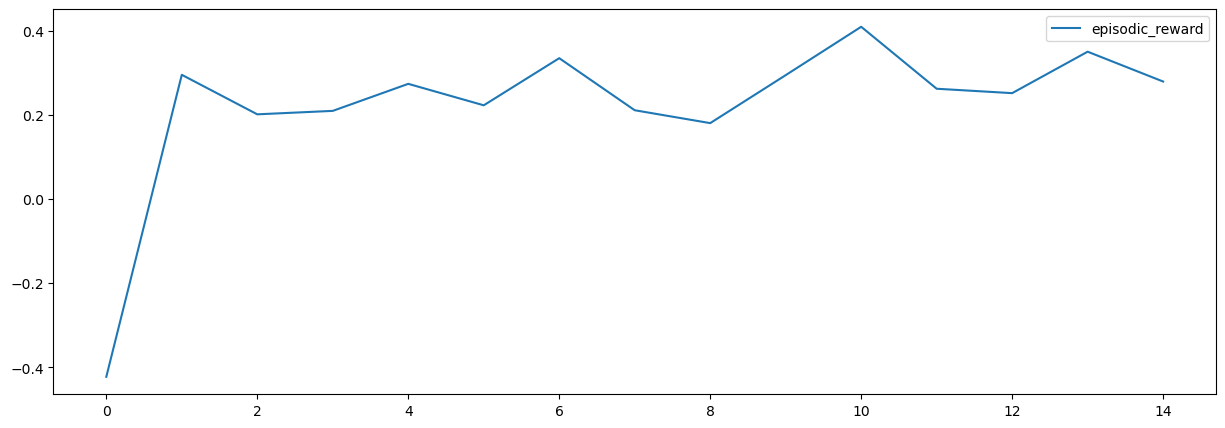

In [8]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

all_metrics.plot(y=["episodic_reward"], figsize=(15, 5))
plt.show()

In [9]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
for i in range(10):
    x, y = stationaryDGP()
    spread = y - x
    _df = pd.DataFrame({'x': x, 'y': y, 'close': spread})
    fe = FeatureEngineering(_df, main_feature_col="close")
    fe.rolling_feature(**feature_config)
    _df = fe.df.copy()
    
    env_test = gym.make("TradingEnv",
            name= "stationaryDGP",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            dynamic_feature_functions = [],
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return :  0.30%   |   Portfolio Return : 21.34%   |   Position Changes : 2112   |   Episode Length : 10000   |   
Market Return :  0.33%   |   Portfolio Return : 15.09%   |   Position Changes : 2040   |   Episode Length : 10000   |   
Market Return :  0.09%   |   Portfolio Return : 15.22%   |   Position Changes : 2019   |   Episode Length : 10000   |   
Market Return : -0.10%   |   Portfolio Return : 34.09%   |   Position Changes : 2129   |   Episode Length : 10000   |   
Market Return : -0.09%   |   Portfolio Return : 17.58%   |   Position Changes : 2094   |   Episode Length : 10000   |   
Market Return : -0.40%   |   Portfolio Return : 22.48%   |   Position Changes : 2098   |   Episode Length : 10000   |   
Market Return :  0.22%   |   Portfolio Return : 23.79%   |   Position Changes : 2084   |   Episode Length : 10000   |   
Market Return :  0.48%   |   Portfolio Return : 16.21%   |   Position Changes : 2078   |   Episode Length : 10000   |   
Market Return :  0.12%   |   Por

In [10]:
# from gym_trading_env.renderer import Renderer
# renderer = Renderer(render_logs_dir="render_logs")
# renderer.run()

In [11]:
# build features
df_train = df.copy()

feature_config = {
    "window": 1, # 7 days window, pad with first value when window is not available
    "mode": "log_pctchg" # difference between current and previous close price
}

fe = FeatureEngineering(df_train, main_feature_col="close")
fe.rolling_feature(**feature_config)
df_train = fe.df.copy()
df_train

,x,y,close,feature_rolling_0
0,9.976695,110.026495,100.049800,0.000000
1,9.990551,110.070197,100.079646,0.029845
2,9.994797,110.226770,100.231973,0.152328
3,9.933667,110.310651,100.376984,0.145011
4,10.032829,110.354142,100.321313,-0.055671
...,...,...,...,...
9995,16.758558,116.513404,99.754846,-0.035523
9996,16.731581,116.530838,99.799256,0.044410
9997,16.741496,116.755935,100.014439,0.215183
9998,16.716588,116.584431,99.867842,-0.146597


In [12]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationaryDGP",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)
while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(0)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[0. 0. 0.]
Market Return : -0.10%   |   Portfolio Return :  0.09%   |   Position Changes : 1   |   Episode Length : 10000   |   


In [13]:
agent = XGBoostAgent(n_observations, n_actions)
history_metrics, _ = agent.train(env, num_episodes=20, replay_every=2)

Market Return : -0.10%   |   Portfolio Return : -62.87%   |   Position Changes : 6626   |   Episode Length : 10000   |   
Market Return : -0.10%   |   Portfolio Return : -62.49%   |   Position Changes : 6648   |   Episode Length : 10000   |   
Market Return : -0.10%   |   Portfolio Return : -55.94%   |   Position Changes : 4941   |   Episode Length : 10000   |   
Market Return : -0.10%   |   Portfolio Return : -56.48%   |   Position Changes : 4994   |   Episode Length : 10000   |   
Market Return : -0.10%   |   Portfolio Return : -39.74%   |   Position Changes : 2995   |   Episode Length : 10000   |   
Market Return : -0.10%   |   Portfolio Return : -37.90%   |   Position Changes : 2920   |   Episode Length : 10000   |   
Market Return : -0.10%   |   Portfolio Return : -14.42%   |   Position Changes : 1527   |   Episode Length : 10000   |   
Market Return : -0.10%   |   Portfolio Return : -21.15%   |   Position Changes : 1580   |   Episode Length : 10000   |   
Market Return : -0.10%  

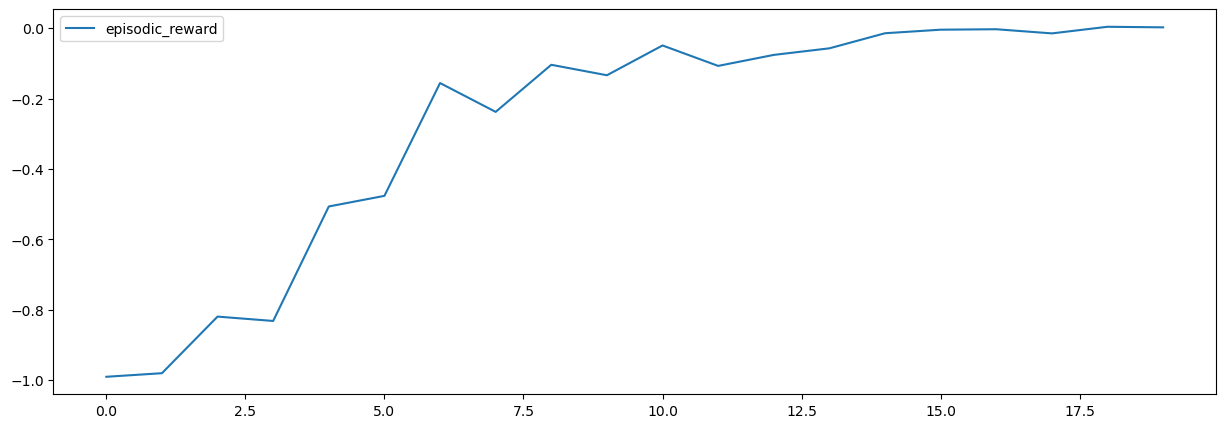

In [14]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

all_metrics.plot(y=["episodic_reward"], figsize=(15, 5))
plt.show()

In [16]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
for i in range(10):
    x, y = stationaryDGP()
    spread = y - x
    _df = pd.DataFrame({'x': x, 'y': y, 'close': spread})
    fe = FeatureEngineering(_df, main_feature_col="close")
    fe.rolling_feature(**feature_config)
    _df = fe.df.copy()

    env_test = gym.make("TradingEnv",
            name= "stationaryDGP",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return : -0.06%   |   Portfolio Return :  0.04%   |   Position Changes : 1   |   Episode Length : 10000   |   
Market Return :  0.00%   |   Portfolio Return : -0.00%   |   Position Changes : 0   |   Episode Length : 10000   |   
Market Return : -0.21%   |   Portfolio Return :  0.21%   |   Position Changes : 0   |   Episode Length : 10000   |   
Market Return : -0.44%   |   Portfolio Return :  0.43%   |   Position Changes : 1   |   Episode Length : 10000   |   
Market Return :  0.08%   |   Portfolio Return : -0.10%   |   Position Changes : 1   |   Episode Length : 10000   |   
Market Return :  0.37%   |   Portfolio Return : -0.38%   |   Position Changes : 1   |   Episode Length : 10000   |   
Market Return :  0.06%   |   Portfolio Return : -0.08%   |   Position Changes : 1   |   Episode Length : 10000   |   
Market Return : -0.17%   |   Portfolio Return :  0.15%   |   Position Changes : 1   |   Episode Length : 10000   |   
Market Return : -0.12%   |   Portfolio Return :  0.12%  